### Detect Subduction Initiation/Death

- The purpose of this notebook is to automatically detect the appearance of new subduction zones, and disappearance of existing ones, within a topological plate model
- The method compares subduction configurations against the configuration at the previous or next time snapshot, then examines the distance between each vertex along the subduction boundary at time t with the configuration at time t=t+dt or t=t-dt.
- The distance is unlikely to be zero between timesteps, even where subduction persists, due to trench migration. So we must set a distance threshold to distinguish between changes in the configuration that reflect trench migration (small distance) and changes that reflect addition or removal of an entire segment.
- This does not work perfectly. In many cases, the subduction line geometries change between time steps for reasons that are ambiguous (but in many cases probably not becuase the model is intended to imply actual wholesale changes in the plate boundary??). The code distinguishes between place where the subduction zone moves a lot but the plate pair across the boundary remains the same, as opposed to places where the plate pair changes (hence more likely to be a genuine change in plate boundary configuration?)
- Various lines also included for handling of bad topological segments (for these segements, plate pair cannot be determined but still used for distance check).
- Also added code to detect distance to nearest continental polygon at time of initiation/death

In [1]:
import pygplates
import numpy as np
from mpl_toolkits.basemap import Basemap
from topology_plotting import *
from matplotlib.patches import Polygon
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Specify some input files

#rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'
#input_topology_filename = '../tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'
#topology_features = pygplates.FeatureCollection(input_topology_filename)


rotation_filename = './MullerData/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
GPML_List = ['./MullerData/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',\
                          './MullerData/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']



rotation_model = pygplates.RotationModel(rotation_filename)

topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)

# Static polygons to determine whether subduction segment is adjacent to continent or not
static_polygon_filename = './MullerData/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v15.gpmlz'
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
continental_polygon_features = []
for feature in static_polygon_features:
    if feature.get_feature_type() == pygplates.FeatureType.gpml_closed_continental_boundary:
        continental_polygon_features.append(feature)




# Run subduction initiation

# Time range and time increment for convergence velocity calculation
time_step = 1.
time_offset = 1.
time_start = 0
time_end = 231.


# Plotting for subduction initiation 
df_Initiation = pd.read_csv('./subduction_initiation_230_0.csv')

df_Death = pd.read_csv('./subduction_death_230_0.csv')

 

/Users/simon/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


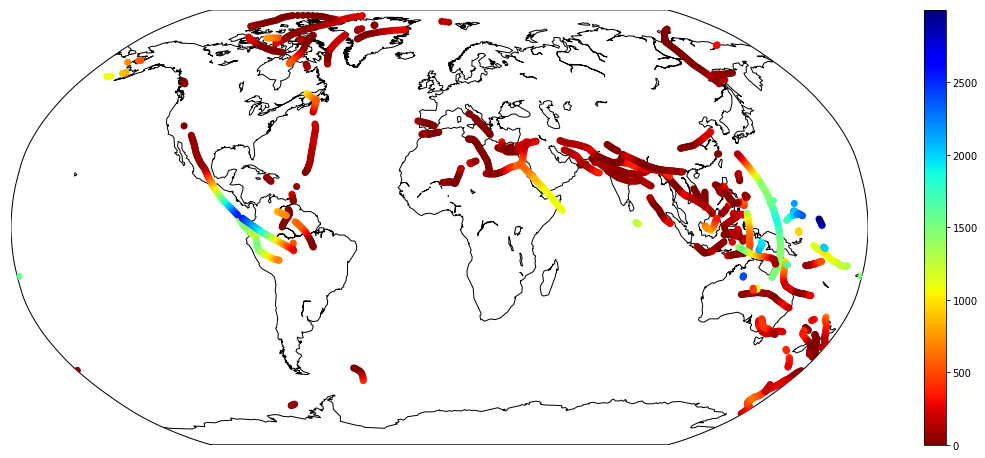

In [2]:
from mpl_toolkits.basemap import Basemap

LLSVP_edge_filename = '/Users/Simon/Data/SeismicTomography/SMEAN/SMEANSLOW1'

subset = df_Initiation[(df_Initiation['dist2sz']<-200.)]

plt.figure(figsize=(20,8))

m = Basemap(projection='robin',lon_0=0)
m.drawcoastlines()
#m.readshapefile(LLSVP_edge_filename,'tmp',color='r',linewidth=3,zorder=2)

x,y = m(np.array(subset['lon']),np.array(subset['lat']))
m.scatter(x,y,c=np.array(subset['dist2cont']),
            s=50,edgecolors='',zorder=3,cmap=plt.cm.jet_r)
m.plot(x,y,'.',color='gray',zorder=1,alpha=0.02)

plt.colorbar()
plt.show()

# Explanation
# The coloured lines are subduction initiation sites according to the logic of the code,
# coloured by age
# The grey transparent points are all subduction zones



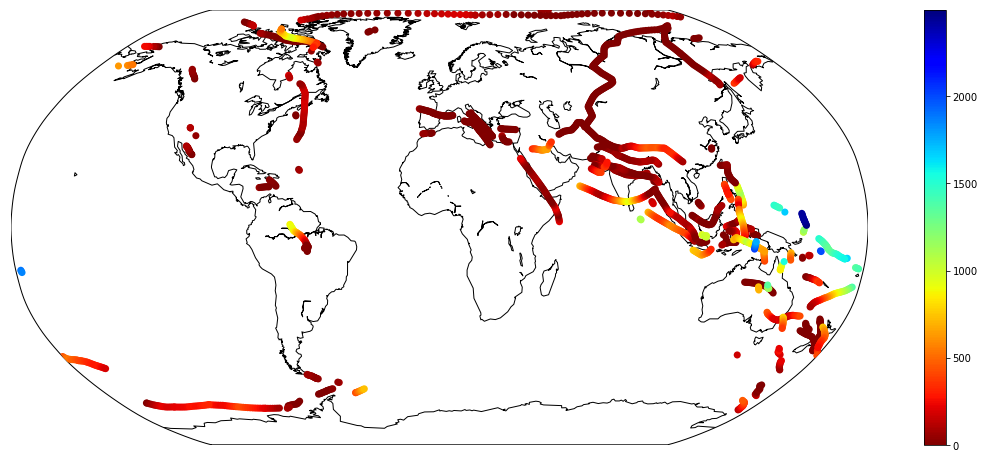

In [3]:
subset = df_Death[(df_Death['dist2sz']<-200.)]

plt.figure(figsize=(20,8))

m = Basemap(projection='robin',lon_0=0)
m.drawcoastlines()
#m.readshapefile(LLSVP_edge_filename,'tmp',color='r',linewidth=3,zorder=2)

x,y = m(np.array(subset['lon']),np.array(subset['lat']))
m.scatter(x,y,c=np.array(subset['dist2cont']),
            s=50,edgecolors='',zorder=3,cmap=plt.cm.jet_r)
#x,y = m(np.array(df_mes['lon']),np.array(df_mes['lat']))
m.plot(x,y,'.',color='gray',zorder=1,alpha=0.02)

plt.colorbar()
plt.show()



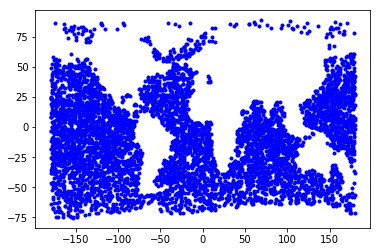

calculating random distribution for 0 Ma
calculating random distribution for 5 Ma
calculating random distribution for 10 Ma
calculating random distribution for 15 Ma
calculating random distribution for 20 Ma
calculating random distribution for 25 Ma
calculating random distribution for 30 Ma
calculating random distribution for 35 Ma
calculating random distribution for 40 Ma
calculating random distribution for 45 Ma
calculating random distribution for 50 Ma


In [ ]:
# Function to get distance to nearest continental polygon (should be reconstructed already)
def get_nearest_continental_polygon(seed_point,continental_polygons):
    
    min_distance_to_all_features = np.radians(180)
    nearest_continent = None        

    for polygon in continental_polygons:
        if polygon is not None:
            min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                polygon.get_reconstructed_geometry(),
                seed_point,
                min_distance_to_all_features,
                geometry1_is_solid=True)

            # If the current geometry is nearer than all previous geometries then
            # its associated feature is the nearest feature so far.
            if min_distance_to_feature is not None:
                min_distance_to_all_features = min_distance_to_feature
                nearest_continent = polygon.get_feature().get_reconstruction_plate_id()
                    
    return min_distance_to_all_features*pygplates.Earth.mean_radius_in_kms



#import sys
#sys.path.append('/Users/Simon/GIT/gplates-web/django/GWS/utils/')
#from sphere_tools import random_points_feature

def marsaglias_method(N):

    ## Marsaglia's method
    dim = 3
    
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius

    return points


def random_points_on_sphere(N):
# function to call Marsaglia's method and return Long/
# Lat arrays

    points = marsaglias_method(N)

    Long=[]
    Lat=[]
    for xyz in points.T:
        LL = pygplates.PointOnSphere((xyz))
        Lat.append(LL.to_lat_lon()[0])
        Long.append(LL.to_lat_lon()[1])

    return np.array(Long), np.array(Lat)


def random_points_feature(N,filename=None):
# function to call Marsaglia's method and return
# feature collection or save to file

    points = marsaglias_method(N)

    #multipoint = pygplates.MultiPointOnSphere((points.T))
    multipoint_feature = pygplates.Feature()
    multipoint_feature.set_geometry(pygplates.MultiPointOnSphere((points.T)))
    multipoint_feature.set_name('Random Points from Marsaglia''s method')

    multipoint_feature_collection = pygplates.FeatureCollection(multipoint_feature)

    if filename is not None:
        multipoint_feature_collection.write(filename)
    else:
        return multipoint_feature_collection

random_points = random_points_feature(10000)

assigned_point_features = pygplates.partition_into_plates(
            continental_polygon_features,
            rotation_model,
            random_points,
            properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])

tmpX = []
tmpY = []
for assigned_point_feature in assigned_point_features:
    if assigned_point_feature.get_reconstruction_plate_id()==0:
        tmpX.append(assigned_point_feature.get_geometry().to_lat_lon_array()[:,1])
        tmpY.append(assigned_point_feature.get_geometry().to_lat_lon_array()[:,0])

plt.plot(tmpX,tmpY,'b.')
plt.show()


# Loop to generate random points and distance to continents for 
# a coarse series of times, save them all to csv
df_random = pd.DataFrame(columns=['Age','dist2cont'])

coarse_time_list = np.arange(0,231,5)
for time in coarse_time_list:
    
    print 'calculating random distribution for %d Ma' % time
    dists = []
    reconstructed_continental_polygons = []
    pygplates.reconstruct(continental_polygon_features,
                          rotation_model,
                          reconstructed_continental_polygons,
                          time,
                          anchor_plate_id=0)
    
    for multipoint in random_points:
        for point in multipoint.get_all_geometries()[0].get_points():
            #print point
            d2c = get_nearest_continental_polygon(point,reconstructed_continental_polygons)
            dists.append(d2c)

    tmp = pd.DataFrame(data={'Age':pd.Series(time*np.ones(len(dists))), 'dist2cont':pd.Series(dists)})
    df_random = df_random.append(tmp)
    

df_random.to_csv('random_points_10000pt_5Myr.csv')



/Users/simon/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


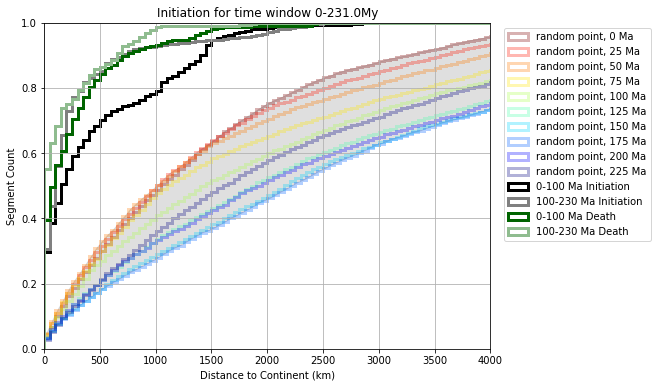

In [6]:
plt.figure(figsize=(8,6))

# PLOTTING OF RANDOM POINT DISTRIBUTIONS
# - LOOP OVER A SERIES OF TIMES TO GET DISTRIBUTIONS FOR EACH, ADD COLOURED LINES
coarse_time_list = np.arange(0,231,25)
color_idx = np.linspace(0, 1, len(coarse_time_list))
hlist = []
for i,time in zip(color_idx,coarse_time_list):
    
    random_subset=df_random[(df_random.Age==time) & (df_random.dist2cont>0)]
    n = plt.hist(random_subset.dist2cont,bins=np.arange(0,10001,50),
             color=plt.cm.jet_r(i),cumulative=True,normed=True,histtype='step',
             label='random point, %s Ma' % time,
             linewidth=3,alpha=0.3)
    hlist.append(n[0])

plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)

# PLOTTING OF DISTRIBUTIONS FOR INITIATION
subset = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']<=230.) ]
subset_rec = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']<=100.)]
subset_old = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']>100.)]

plt.hist(subset_rec['dist2cont'],bins=np.arange(0,10001,50),
         color='black',linewidth=3,cumulative=True,normed=True,histtype='step',label='0-100 Ma Initiation')
plt.hist(subset_old['dist2cont'],bins=np.arange(0,10001,50),
         color='gray',linewidth=3,cumulative=True,normed=True,histtype='step',label='100-230 Ma Initiation')


# PLOTTING OF DISTRIBUTIONS FOR DEATH
subset = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']<=230.) ]
subset_rec = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']<=100.)]
subset_old = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']>100.)]

plt.hist(subset_rec['dist2cont'],bins=np.arange(0,10001,50),
         color='darkgreen',linewidth=3,cumulative=True,normed=True,histtype='step',label='0-100 Ma Death')
plt.hist(subset_old['dist2cont'],bins=np.arange(0,10001,50),
         color='darkseagreen',linewidth=3,cumulative=True,normed=True,histtype='step',label='100-230 Ma Death')


plt.xlabel('Distance to Continent (km)')
plt.ylabel('Segment Count')
plt.xlim(0,4000)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title('Initiation for time window '+str(time_start)+'-'+str(time_end)+'My')
plt.grid()
plt.show()




calculating random distribution for 0 Ma
calculating random distribution for 25 Ma
calculating random distribution for 50 Ma
calculating random distribution for 75 Ma
calculating random distribution for 100 Ma
calculating random distribution for 125 Ma
calculating random distribution for 150 Ma
calculating random distribution for 175 Ma
calculating random distribution for 200 Ma
calculating random distribution for 225 Ma


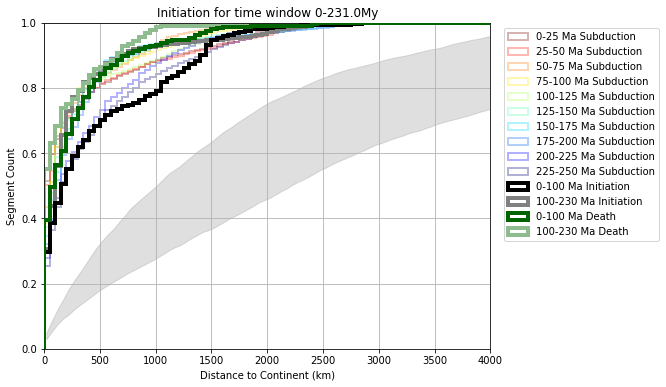

In [7]:
plt.figure(figsize=(8,6))

plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)

coarse_time_step = 25.
coarse_time_list = np.arange(0,231,coarse_time_step)
color_idx = np.linspace(0, 1, len(coarse_time_list))

for i,time in zip(color_idx,coarse_time_list):
    print 'calculating random distribution for %d Ma' % time
    # PLOTTING OF DISTRIBUTIONS FOR INITIATION
    subset = df_Initiation[(df_Initiation['Age']>=time) & (df_Initiation['Age']<time+coarse_time_step)]
    plt.hist(subset['dist2cont'],bins=np.arange(0,10001,50),
             color=plt.cm.jet_r(i),linewidth=2,alpha=0.3,
             cumulative=True,normed=True,histtype='step',
             label='%d-%d Ma Subduction' % (time,time+coarse_time_step))

    
# PLOTTING OF DISTRIBUTIONS FOR INITIATION
subset = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']<=230.) ]
subset_rec = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']<=100.)]
subset_old = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']>100.)]

plt.hist(subset_rec['dist2cont'],bins=np.arange(0,10001,50),
         color='black',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='0-100 Ma Initiation',zorder=3)
plt.hist(subset_old['dist2cont'],bins=np.arange(0,10001,50),
         color='gray',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='100-230 Ma Initiation',zorder=2)


# PLOTTING OF DISTRIBUTIONS FOR DEATH
subset = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']<=230.) ]
subset_rec = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']<=100.)]
subset_old = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']>100.)]

plt.hist(subset_rec['dist2cont'],bins=np.arange(0,10001,50),
         color='darkgreen',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='0-100 Ma Death',zorder=3)
plt.hist(subset_old['dist2cont'],bins=np.arange(0,10001,50),
         color='darkseagreen',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='100-230 Ma Death',zorder=2)


plt.xlabel('Distance to Continent (km)')
plt.ylabel('Segment Count')
plt.xlim(0,4000)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title('Initiation for time window '+str(time_start)+'-'+str(time_end)+'My')
plt.grid()
plt.show()




calculating random distribution for 0 Ma
calculating random distribution for 25 Ma
calculating random distribution for 50 Ma
calculating random distribution for 75 Ma
calculating random distribution for 100 Ma
calculating random distribution for 125 Ma
calculating random distribution for 150 Ma
calculating random distribution for 175 Ma
calculating random distribution for 200 Ma
calculating random distribution for 225 Ma


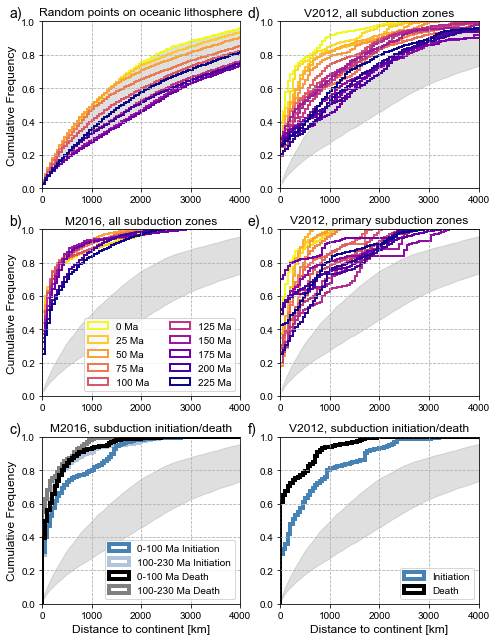

In [11]:
import pycpt
import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True

label_x_offset = -660
fs = 12

# Load the csv files for the van der Meer subduction
df_VDM_2009 = pd.read_csv('./VDM_subduction_distances_2009list.csv')    
df_VDM_all = pd.read_csv('./VDM_subduction_distances.csv')    
unique_times = df_VDM_all.Age.unique()

unique_times.sort()

cmap = plt.cm.plasma_r

plt.figure(figsize=(7,9))

plt.subplot(321)
plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)
coarse_time_list = np.arange(0,231,25)
color_idx = np.linspace(0, 1, len(coarse_time_list))
hlist = []
for i,time in zip(color_idx,coarse_time_list):
    
    random_subset=df_random[(df_random.Age==time) & (df_random.dist2cont>0)]
    n = plt.hist(random_subset.dist2cont,bins=np.arange(0,10001,50),
                 color=cmap(i),cumulative=True,normed=True,histtype='step',
                 label='%s Ma' % time,linewidth=2)
    hlist.append(n[0])
plt.ylabel('Cumulative Frequency',fontsize=fs)
plt.xlim(0,4000)
plt.ylim(0,1)
plt.grid(zorder=0,linestyle='--')
plt.text(label_x_offset,1.025,'a)',fontsize=14)
plt.title('Random points on oceanic lithosphere')

plt.subplot(323)
plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)
for i,time in zip(color_idx,coarse_time_list):
    print 'calculating random distribution for %d Ma' % time
    # PLOTTING OF DISTRIBUTIONS FOR INITIATION
    subset = df_Initiation[(df_Initiation['Age']>=time) & (df_Initiation['Age']<time+coarse_time_step)]
    plt.hist(subset['dist2cont'],bins=np.arange(0,10001,50),
             color=cmap(i),linewidth=2,
             cumulative=True,normed=True,histtype='step',
             label='%d Ma' % (time))
plt.ylabel('Cumulative Frequency',fontsize=fs)
plt.xlim(0,4000)
plt.ylim(0,1)
plt.grid(zorder=0,linestyle='--')
plt.legend(loc='lower right', ncol=2)
plt.text(label_x_offset,1.025,'b)',fontsize=14)
plt.title('M2016, all subduction zones')

plt.subplot(325)
plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)
# PLOTTING OF DISTRIBUTIONS FOR INITIATION
subset = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']<=230.) ]
subset_rec = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']<100.)]
subset_old = df_Initiation[(df_Initiation['dist2sz']<-200.) & (df_Initiation['Age']>=100.)]

plt.hist(subset_rec['dist2cont'],bins=np.arange(0,10001,50),
         color='steelblue',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='0-100 Ma Initiation',zorder=3)
plt.hist(subset_old['dist2cont'],bins=np.arange(0,10001,50),
         color='lightsteelblue',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='100-230 Ma Initiation',zorder=2)

# PLOTTING OF DISTRIBUTIONS FOR DEATH
subset = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']<=230.) ]
subset_rec = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']<=100.)]
subset_old = df_Death[(df_Death['dist2sz']<-200.) & (df_Death['Age']>100.)]

plt.hist(subset_rec['dist2cont'],bins=np.arange(0,10001,50),
         color='black',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='0-100 Ma Death',zorder=3)
plt.hist(subset_old['dist2cont'],bins=np.arange(0,10001,50),
         color='gray',linewidth=4,cumulative=True,normed=True,histtype='step',
         label='100-230 Ma Death',zorder=2)
plt.ylabel('Cumulative Frequency',fontsize=fs)
plt.xlim(0,4000)
plt.ylim(0,1)
plt.grid(zorder=0,linestyle='--')
plt.legend(loc='lower right')
plt.xlabel('Distance to continent [km]',fontsize=fs)

plt.text(label_x_offset,1.025,'c)',fontsize=14)
plt.title('M2016, subduction initiation/death')


plt.subplot(322)
plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)
color_idx = np.linspace(0, 1, len(unique_times))
for index,(i,time) in enumerate(zip(color_idx,unique_times)):
    vsubset = df_VDM_all[df_VDM_all['Age']==time]
    plt.hist(vsubset['dist2cont'],bins=np.arange(0,8001,50),
             color=cmap(i),cumulative=True,normed=True,histtype='step',
             label=str(time),linewidth=2)
plt.xlim(0,4000)
plt.ylim(0,1)
plt.grid(zorder=0,linestyle='--')

plt.text(label_x_offset,1.025,'d)',fontsize=14)
plt.title('V2012, all subduction zones')


plt.subplot(324)
plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)
for index,(i,time) in enumerate(zip(color_idx,unique_times)):
    vsubset = df_VDM_2009[df_VDM_2009['Age']==time]
    plt.hist(vsubset['dist2cont'],bins=np.arange(0,8001,50),
             color=cmap(i),cumulative=True,normed=True,histtype='step',
             label=str(time),linewidth=2)
plt.xlim(0,4000)
plt.ylim(0,1)
plt.grid(zorder=0,linestyle='--')

plt.text(label_x_offset,1.025,'e)',fontsize=14)
plt.title('V2012, primary subduction zones')



plt.subplot(326)
plt.fill_between(n[1][:-1]+25,np.array(hlist).min(axis=0),np.array(hlist).max(axis=0),
                 color='gray',alpha=0.25)
df_init = pd.read_csv('./VDM_subduction_initiation.csv')
df_death = pd.read_csv('./VDM_subduction_death.csv')
df_death=df_death[df_death['Age']>10]
plt.hist(np.array(df_init['dist2cont']),bins=np.arange(0,8001,50),
         cumulative=True,normed=True,histtype='step',
         linewidth=4,color='steelblue',label='Initiation')
plt.hist(np.array(df_death['dist2cont']),bins=np.arange(0,8001,50),
         cumulative=True,normed=True,histtype='step',
         linewidth=4,color='black',label='Death')
plt.xlim(0,4000)
plt.ylim(0,1)
plt.grid(zorder=0,linestyle='--')
plt.xlabel('Distance to continent [km]',fontsize=fs)
plt.legend(loc='lower right')

plt.text(label_x_offset,1.025,'f)',fontsize=14)
plt.title('V2012, subduction initiation/death')

plt.tight_layout(w_pad=0.6)

plt.savefig('Reconstructed_Subduction_In_Relation_To_Continents.pdf',format='pdf')

plt.show()

